In [27]:
#url: /home/delameta-dl/Documents/chest_xray

import time 
import copy 
import glob
import random 

import numpy as np 
import pandas as pd 
from PIL import Image 

from tqdm.auto import tqdm 
from matplotlib import pyplot as plt 
from sklearn.model_selection import train_test_split 

import torch 
import torch.nn as nn 
from torch.optim import Adam 
from torch.utils.data import Dataset, DataLoader 
from torchvision import transforms 
from torchvision.models import resnet18, resnet34 


In [29]:
train_normal = glob.glob('/home/delameta-dl/Documents/chest_xray/train/NORMAL/*')
train_pneumonia = glob.glob('/home/delameta-dl/Documents/chest_xray/train/PNEUMONIA/*')

test_normal = glob.glob("/home/delameta-dl/Documents/chest_xray/test/NORMAL/*")
test_pneumonia = glob.glob("/home/delameta-dl/Documents/chest_xray/test/PNEUMONIA/*")

In [30]:
train_paths = train_normal + train_pneumonia
test_paths = test_normal + test_pneumonia

In [31]:
train_labels = [0]*len(train_normal) + [1]*len(train_pneumonia)
test_labels = [0]*len(test_normal) + [1]*len(test_pneumonia)

print(len(train_paths), len(train_labels))
print(len(test_paths), len(test_labels))

5216 5216
624 624


In [32]:
train_paths, valid_paths, train_labels, valid_labels = train_test_split(train_paths, train_labels,stratify=train_labels)



In [33]:
def show_random_images():
    path_random_normal = random.choice(train_normal)
    path_random_abnormal = random.choice(train_pneumonia)

    fig = plt.figure(figsize=(10,10))
    ax1 = plt.subplot(1, 2, 1)
    ax1.imshow(Image.open(path_random_normal).convert("LA"))
    ax1.set_title("Normal X-ray")
    
    ax2 = plt.subplot(1, 2, 2)
    ax2.imshow(Image.open(path_random_abnormal).convert("LA"))
    ax2.set_title("Abnormal X-ray")

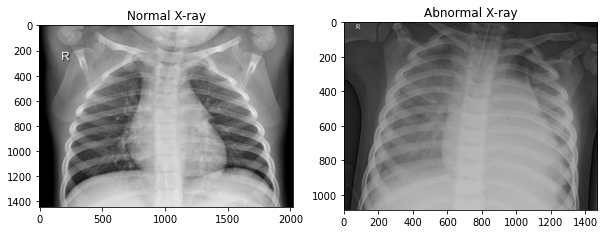

In [34]:
show_random_images()

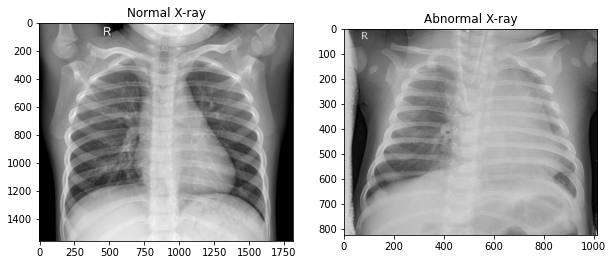

In [35]:
show_random_images()

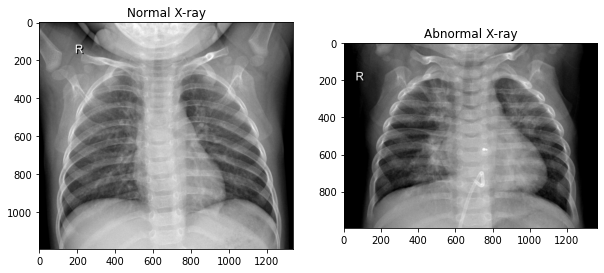

In [36]:
show_random_images()

In [43]:
class XrayDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        path = self.paths[index]
        image = Image.open(path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        label = self.labels[index]
        label = torch.tensor([label])
        
        return image, label

In [41]:
class PneumoniaNet(nn.Module):
    def __init__(self, pretrained=True):
        super(PneumoniaNet, self).__init__()
        self.backbone = resnet18(pretrained=pretrained)
        self.fc = nn.Linear(in_features=512, out_features=1) 
    
    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)        
        x = self.backbone.relu(x)       
        x = self.backbone.maxpool(x)  
        
        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)        
        x = self.backbone.layer3(x)        
        x = self.backbone.layer4(x)
        
        x = self.backbone.avgpool(x)
        
        x = x.view(x.size(0), 512)
        x = self.fc(x)
        
        return x

In [44]:
image_size = (500, 500)

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=15),
    transforms.Resize(size=image_size),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=image_size),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = XrayDataset(train_paths, train_labels, train_transform)
valid_dataset = XrayDataset(valid_paths, valid_labels, test_transform)

In [45]:
pretrained = True

model = PneumoniaNet(pretrained=pretrained)

lr = 3e-3

num_epochs = 5
train_batch_size = 16
valid_batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, num_workers=5, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=valid_batch_size, num_workers=5, shuffle=False)


dataloaders = {
    "train": train_dataloader,
    "val": valid_dataloader
}

logging_steps = {
    "train": len(dataloaders["train"]) // 10,
    "val": len(dataloaders["val"]) // 10
}

dataset_sizes = {
    "train": len(train_dataset),
    "val": len(valid_dataset)
}

batch_sizes = {
    "train": train_batch_size,
    "val": valid_batch_size
}

criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=lr)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/delameta-dl/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:38<00:00, 1.23MB/s]


In [46]:
model.cuda()

PneumoniaNet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [47]:
!nvidia-smi

Sat Oct 30 13:27:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.142.00   Driver Version: 450.142.00   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 105...  Off  | 00000000:01:00.0  On |                  N/A |
| 40%   36C    P0    N/A /  75W |    962MiB /  4038MiB |     25%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 105...  Off  | 00000000:02:00.0 Off |                  N/A |
| 41%   

In [49]:
def train_model(model, criterion, optimizer, num_epochs, device="cuda"):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0
    
    for epoch in tqdm(range(num_epochs), leave=False):
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for i, (inputs, labels) in tqdm(enumerate(dataloaders[phase]), 
                                            leave=False, 
                                            total=len(dataloaders[phase])):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    
                    preds = outputs.sigmoid() > 0.5
                    loss = criterion(outputs, labels.float())
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                if (i % logging_steps[phase] == 0) & (i > 0):
                    avg_loss = running_loss / ((i+1) * batch_sizes[phase])
                    avg_acc = running_corrects / ((i+1) * batch_sizes[phase])   
                    
                    print(f"[{phase}]: {epoch+1} / {num_epochs} | loss : {avg_loss} | acc : {avg_acc}")
                    
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            
            
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
    time_elapsed = time.time() - since
    
    print(f"training took {time_elapsed} seconds")
    
    model.load_state_dict(best_model_wts)
    
    return model

In [50]:
model = train_model(model, criterion, optimizer, num_epochs)

  0%|          | 0/5 [00:00<?, ?it/s]

[train]: 1 / 5 | loss : 0.5208280068635941 | acc : 0.7949999570846558


[train]: 1 / 5 | loss : 0.3892538880511206 | acc : 0.8405612111091614


[train]: 1 / 5 | loss : 0.3580194980110208 | acc : 0.8518835306167603


[train]: 1 / 5 | loss : 0.31791068521357074 | acc : 0.8692010045051575


[train]: 1 / 5 | loss : 0.3001006467899015 | acc : 0.8755164742469788


[train]: 1 / 5 | loss : 0.28502774780680395 | acc : 0.8806034326553345


[train]: 1 / 5 | loss : 0.27617829755918516 | acc : 0.8860946893692017


[train]: 1 / 5 | loss : 0.27204631907875054 | acc : 0.8866580128669739


[train]: 1 / 5 | loss : 0.26167828308993496 | acc : 0.8919931054115295


[train]: 1 / 5 | loss : 0.25907677122975287 | acc : 0.892634928226471


train Loss: 0.2605 Acc: 0.8921


[val]: 1 / 5 | loss : 0.2758865221920941 | acc : 0.881944477558136


[val]: 1 / 5 | loss : 0.2772329185596284 | acc : 0.8823529481887817


[val]: 1 / 5 | loss : 0.2976489742100239 | acc : 0.8799999952316284


[val]: 1 / 5 | loss : 0.28600337345040205 | acc : 0.884469747543335


[val]: 1 / 5 | loss : 0.27665797739130693 | acc : 0.8841463327407837


[val]: 1 / 5 | loss : 0.26894802258026845 | acc : 0.8864795565605164


[val]: 1 / 5 | loss : 0.27101971359367955 | acc : 0.8848684430122375


[val]: 1 / 5 | loss : 0.2735236137532271 | acc : 0.8865384459495544


[val]: 1 / 5 | loss : 0.28094498093609943 | acc : 0.886130154132843


 20%|██        | 1/5 [03:09<12:38, 189.64s/it]

[val]: 1 / 5 | loss : 0.2842342873322375 | acc : 0.8865740895271301
val Loss: 0.2839 Acc: 0.8865



[train]: 2 / 5 | loss : 0.22147364810109138 | acc : 0.9149999618530273


[train]: 2 / 5 | loss : 0.18753505270091855 | acc : 0.9323979616165161


[train]: 2 / 5 | loss : 0.19750090925762914 | acc : 0.9255136847496033


[train]: 2 / 5 | loss : 0.2175089475151497 | acc : 0.9155927300453186


[train]: 2 / 5 | loss : 0.2112313357051 | acc : 0.9183883666992188


[train]: 2 / 5 | loss : 0.2027830647368883 | acc : 0.9206896424293518


[train]: 2 / 5 | loss : 0.20443234778940678 | acc : 0.9193786978721619


[train]: 2 / 5 | loss : 0.19540019786960103 | acc : 0.9235751032829285


[train]: 2 / 5 | loss : 0.18950332975238218 | acc : 0.9256912469863892


[train]: 2 / 5 | loss : 0.18684301580422213 | acc : 0.9260892868041992


train Loss: 0.1862 Acc: 0.9261


[val]: 2 / 5 | loss : 2.3894787894354925 | acc : 0.4236111044883728


[val]: 2 / 5 | loss : 2.431684571153977 | acc : 0.41911765933036804


[val]: 2 / 5 | loss : 2.3545001745224 | acc : 0.4375


[val]: 2 / 5 | loss : 2.349144473220363 | acc : 0.44128790497779846


[val]: 2 / 5 | loss : 2.1997239575153444 | acc : 0.46341460943222046



 61%|██████    | 50/82 [00:17<00:07,  4.29it/s]

[val]: 2 / 5 | loss : 2.221653092880638 | acc : 0.4566326439380646


[val]: 2 / 5 | loss : 2.2571774689774764 | acc : 0.4517543911933899


[val]: 2 / 5 | loss : 2.2257699902241046 | acc : 0.45480769872665405


[val]: 2 / 5 | loss : 2.197485679632997 | acc : 0.4648972451686859


 40%|████      | 2/5 [06:18<09:27, 189.12s/it]

[val]: 2 / 5 | loss : 2.2186279834052662 | acc : 0.4591049551963806
val Loss: 2.2184 Acc: 0.4594



[train]: 3 / 5 | loss : 0.1628569733351469 | acc : 0.9350000023841858


[train]: 3 / 5 | loss : 0.20767134956407304 | acc : 0.9234693646430969


[train]: 3 / 5 | loss : 0.1835261262085748 | acc : 0.926369845867157


[train]: 3 / 5 | loss : 0.18075325182571853 | acc : 0.9317010045051575


[train]: 3 / 5 | loss : 0.18080766357419906 | acc : 0.930785059928894


[train]: 3 / 5 | loss : 0.1726981943537449 | acc : 0.9340516924858093


[train]: 3 / 5 | loss : 0.17421956571954242 | acc : 0.9334319829940796


[train]: 3 / 5 | loss : 0.16937811945328596 | acc : 0.9342616200447083


[train]: 3 / 5 | loss : 0.16372036084549904 | acc : 0.9360598921775818


[train]: 3 / 5 | loss : 0.1687152394252014 | acc : 0.9349066615104675


train Loss: 0.1679 Acc: 0.9351


[val]: 3 / 5 | loss : 0.19625874360402426 | acc : 0.9236111044883728


[val]: 3 / 5 | loss : 0.2230003164971576 | acc : 0.9154411554336548


[val]: 3 / 5 | loss : 0.23438322238624096 | acc : 0.9149999618530273


[val]: 3 / 5 | loss : 0.23410388595904363 | acc : 0.9090909361839294


[val]: 3 / 5 | loss : 0.20869965287970332 | acc : 0.9192072749137878


[val]: 3 / 5 | loss : 0.2050019732239295 | acc : 0.9158163070678711


[val]: 3 / 5 | loss : 0.20419058726544967 | acc : 0.9144737124443054


[val]: 3 / 5 | loss : 0.20909465385171083 | acc : 0.9144230484962463


[val]: 3 / 5 | loss : 0.21221821382641792 | acc : 0.915239691734314


 60%|██████    | 3/5 [09:25<06:16, 188.38s/it]

[val]: 3 / 5 | loss : 0.20624788386034376 | acc : 0.9158950448036194
val Loss: 0.2061 Acc: 0.9156



[train]: 4 / 5 | loss : 0.14093790225684644 | acc : 0.949999988079071


[train]: 4 / 5 | loss : 0.15167006511925435 | acc : 0.9464285373687744


[train]: 4 / 5 | loss : 0.17134223329796366 | acc : 0.9375


[train]: 4 / 5 | loss : 0.1634600434989966 | acc : 0.9394329786300659


[train]: 4 / 5 | loss : 0.15882591255132325 | acc : 0.9390495419502258


[train]: 4 / 5 | loss : 0.15802485050055487 | acc : 0.9370689392089844


[train]: 4 / 5 | loss : 0.1596463232372816 | acc : 0.9375


[train]: 4 / 5 | loss : 0.15623673741642985 | acc : 0.9404144883155823


[train]: 4 / 5 | loss : 0.15232405745883554 | acc : 0.9421082735061646


[train]: 4 / 5 | loss : 0.14981138692681845 | acc : 0.9439834356307983


train Loss: 0.1486 Acc: 0.9440


[val]: 4 / 5 | loss : 0.19408587076597744 | acc : 0.944444477558136


[val]: 4 / 5 | loss : 0.2057634616161094 | acc : 0.9338235259056091


[val]: 4 / 5 | loss : 0.2134844035282731 | acc : 0.92249995470047


[val]: 4 / 5 | loss : 0.191800052723424 | acc : 0.9280303120613098


[val]: 4 / 5 | loss : 0.17215485909453979 | acc : 0.9374999403953552


[val]: 4 / 5 | loss : 0.16682780087374302 | acc : 0.9400510191917419


[val]: 4 / 5 | loss : 0.1707826644476307 | acc : 0.9385964870452881


[val]: 4 / 5 | loss : 0.1707776145436443 | acc : 0.9384615421295166


[val]: 4 / 5 | loss : 0.17422911342335481 | acc : 0.9383561611175537


 80%|████████  | 4/5 [12:40<03:10, 190.89s/it]

[val]: 4 / 5 | loss : 0.17667790715019277 | acc : 0.9382716417312622
val Loss: 0.1770 Acc: 0.9379



[train]: 5 / 5 | loss : 0.14765983529388904 | acc : 0.9449999928474426


[train]: 5 / 5 | loss : 0.1501534355766311 | acc : 0.9451530575752258


[train]: 5 / 5 | loss : 0.1423893323780535 | acc : 0.9469177722930908


[train]: 5 / 5 | loss : 0.1460404168603193 | acc : 0.9426546096801758


[train]: 5 / 5 | loss : 0.1440859127651192 | acc : 0.9442148208618164


[train]: 5 / 5 | loss : 0.1393334798964447 | acc : 0.9461206793785095


[train]: 5 / 5 | loss : 0.13938681181718612 | acc : 0.9463757276535034


[train]: 5 / 5 | loss : 0.13637629106467097 | acc : 0.9478626847267151


[train]: 5 / 5 | loss : 0.13343001987510425 | acc : 0.9490207433700562


[train]: 5 / 5 | loss : 0.13390323819198424 | acc : 0.9476141333580017


train Loss: 0.1347 Acc: 0.9471


[val]: 5 / 5 | loss : 0.18426202620483106 | acc : 0.9236111044883728


[val]: 5 / 5 | loss : 0.19848202809910565 | acc : 0.9227941036224365


[val]: 5 / 5 | loss : 0.2119241251423955 | acc : 0.9149999618530273


[val]: 5 / 5 | loss : 0.18804237531554518 | acc : 0.9261363744735718


[val]: 5 / 5 | loss : 0.17769292067372944 | acc : 0.9298779964447021


[val]: 5 / 5 | loss : 0.1767502021310585 | acc : 0.9349489808082581


[val]: 5 / 5 | loss : 0.17278698488677802 | acc : 0.9385964870452881


[val]: 5 / 5 | loss : 0.16884716323648508 | acc : 0.9394230842590332


[val]: 5 / 5 | loss : 0.17225639653481442 | acc : 0.9375


[val]: 5 / 5 | loss : 0.17737033283682885 | acc : 0.9405864477157593
val Loss: 0.1774 Acc: 0.9402

training took 943.2174603939056 seconds


In [77]:
test_paths = glob.glob("/home/delameta-dl/Documents/chest_xray/test/NORMAL/*") + glob.glob("/home/delameta-dl/Documents/chest_xray/test/PNEUMONIA/*")
test_labels = [0] * len(glob.glob("/home/delameta-dl/Documents/chest_xray/test/NORMAL/*")) + [1] * len(glob.glob("/home/delameta-dl/Documents/chest_xray/test/PNEUMONIA/*"))

In [78]:
len(test_paths), len(test_labels)

(624, 624)

In [79]:
test_dataset = XrayDataset(test_paths, test_labels, test_transform)

In [80]:
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=False)

In [82]:
y_pred = []
y_true = []

for i, (tensors, labels) in tqdm(enumerate(test_dataloader), leave=False, total=len(test_dataloader)):
    with torch.no_grad():
        predictions = model(tensors.cuda())
        predictions = predictions.sigmoid()
        predictions = predictions > 0.5
        y_pred.append(predictions)
        
        y_true.append(labels)
   

In [83]:
y_pred = torch.cat(y_pred)
y_true = torch.cat(y_true)

In [84]:
y_pred.shape, y_true.shape,

(torch.Size([624, 1]), torch.Size([624, 1]))

In [85]:
y_pred = y_pred.cpu().numpy()
y_true = y_true.numpy()

In [86]:
y_pred = y_pred.astype(np.int64)
y_true = y_true.astype(np.int64)

In [87]:
y_pred = y_pred.reshape(-1)
y_true = y_true.reshape(-1)

In [88]:
from sklearn.metrics import accuracy_score

In [89]:
accuracy_score(y_true, y_pred)

0.7548076923076923